# Time-dependent brier score + 保存图片

Model EST loaded successfully.
Model GBSA loaded successfully.
Model RSF loaded successfully.
Model SurvivalSVM loaded successfully.
Model Coxnet loaded successfully.
Model Coxph loaded successfully.


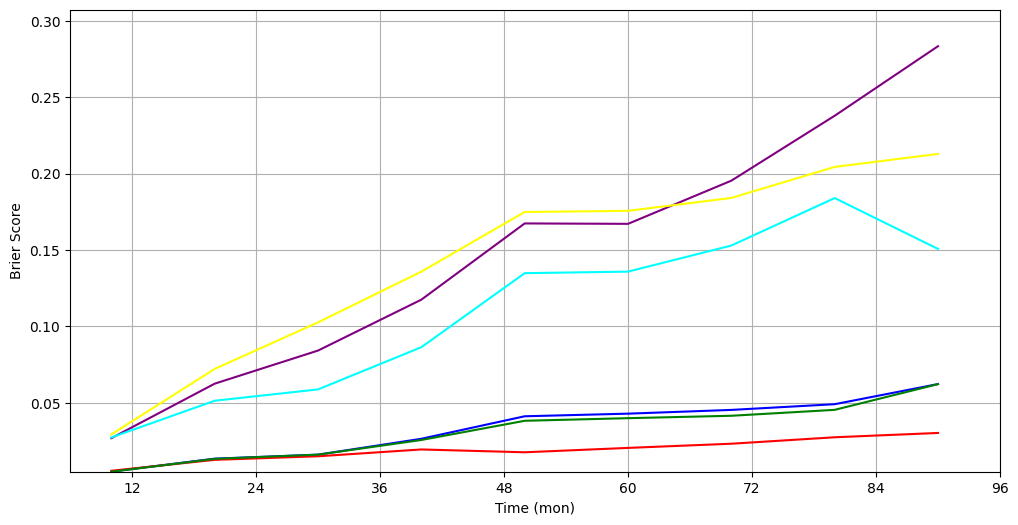

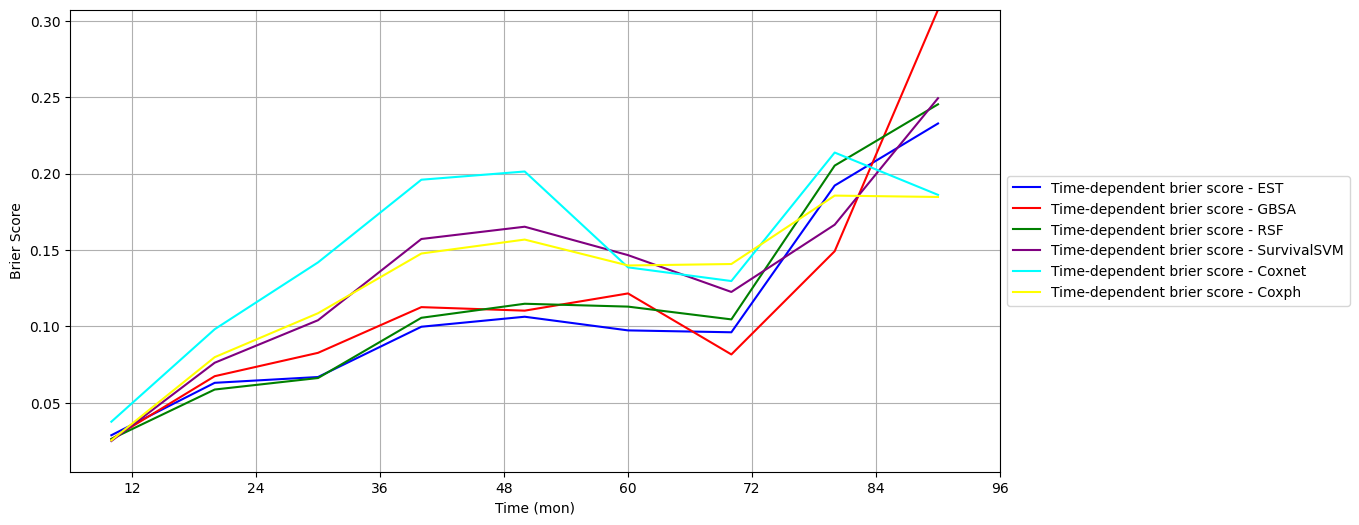

In [1]:
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score
from sklearn.preprocessing import MinMaxScaler

# 读取数据
data = pd.read_csv('dataset.csv')
X = data.drop(['follow_Up', 'outcome'], axis=1)
y = np.array([(event, time) for event, time in zip(data['outcome'], data['follow_Up'])],
             dtype=[('event', bool), ('time', '<f8')])

random_seed = 45
np.random.seed(random_seed)

# 分层抽样划分数据集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=data['outcome'])

# 数据归一化
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 加载所有六个模型
model_names = ["EST", "GBSA", "RSF", "SurvivalSVM", "Coxnet", "Coxph"]
models = {}

for name in model_names:
    try:
        models[name] = joblib.load(f'{name}model.pkl')
        print(f"Model {name} loaded successfully.")
    except Exception as e:
        print(f"Failed to load model {name}: {e}")

# 定义用于评估的时间点
times = np.arange(10, 100, 10)

# 计算预测生存概率的函数
def predict_survival_probabilities(model, X, times):
    if hasattr(model, "predict_survival_function"):  # 对于可以直接预测生存函数的模型
        survs = model.predict_survival_function(X)
        preds = np.asarray([[fn(t) for t in times] for fn in survs])
    else:  # 对于无法直接预测生存概率的模型，使用适当的转换方法
        risk_scores = model.predict(X)
        preds = np.exp(-np.outer(risk_scores, times / times.max()))  # 这种方法仅作为示例
    return preds

# 准备存储每个模型的Brier分数
brier_scores_train = {}
brier_scores_val = {}

# 计算每个模型在训练和验证集上的Brier分数
for name, model in models.items():
    try:
        # 训练集预测和Brier分数
        preds_train = predict_survival_probabilities(model, X_train_scaled, times)
        times_train, brier_train = brier_score(y_train, y_train, preds_train, times)
        brier_scores_train[name] = brier_train
        
        # 验证集预测和Brier分数
        preds_val = predict_survival_probabilities(model, X_val_scaled, times)
        times_val, brier_val = brier_score(y_val, y_val, preds_val, times)
        brier_scores_val[name] = brier_val
    except Exception as e:
        print(f"Failed to compute Brier score for model {name}: {e}")

# 绘图颜色
colors = {
    "EST": "blue",
    "GBSA": "red",
    "RSF": "green",
    "SurvivalSVM": "purple",
    "Coxnet": "cyan",
    "Coxph": "yellow"
}

# 获取所有Brier分数中的最小值和最大值，用于统一纵坐标范围
all_brier_scores = np.concatenate(list(brier_scores_train.values()) + list(brier_scores_val.values()))
y_min, y_max = all_brier_scores.min(), all_brier_scores.max()

# 自定义横坐标标签
custom_xticks = [12, 24, 36, 48, 60, 72, 84, 96]

# 绘制训练集上的Brier分数
plt.figure(figsize=(12, 6))
for name in model_names:
    if name in brier_scores_train:
        plt.plot(times_train, brier_scores_train[name], label=f'Training set - {name}', color=colors[name])
plt.xlabel('Time (mon)')
plt.ylabel('Brier Score')
plt.xticks(custom_xticks)  # 设置自定义横坐标标签
plt.ylim(y_min, y_max)  # 设置纵坐标范围
plt.grid(True)
plt.savefig('training_brier_score.tif', format='tiff')
plt.show()

# 绘制验证集上的Brier分数
plt.figure(figsize=(12, 6))
for name in model_names:
    if name in brier_scores_val:
        plt.plot(times_val, brier_scores_val[name], label=f'Time-dependent brier score - {name}', color=colors[name])
plt.xlabel('Time (mon)')
plt.ylabel('Brier Score')
plt.xticks(custom_xticks)  # 设置自定义横坐标标签
plt.ylim(y_min, y_max)  # 设置纵坐标范围
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 图例在右外侧中间
plt.grid(True)
plt.savefig('validation_brier_score.tif', format='tiff', bbox_inches='tight')
plt.show()
